# Samtools stats per read


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import numpy as np
from pathlib import Path

run_names = {
    "aviti_ngi": "AVITI CB FS",
    "aviti_hq": "AVITI CB",
    "xplus_sns": "NovaSeqX+",
}

custom_params = {"axes.spines.right": False, "axes.spines.top": False}

sns.set_theme(
    context="notebook",
    style="ticks", 
    palette="colorblind",
    font_scale=1.1,
    rc=custom_params
)

basedir = Path("../analysis/error_rate")

# For SVG output
plt.rcParams['svg.fonttype'] = 'none'
figdir = Path("../figures/svg")


In [2]:
%load_ext watermark

In [3]:
%watermark

Last updated: 2025-02-17T10:01:39.657584+01:00

Python implementation: CPython
Python version       : 3.12.6
IPython version      : 8.28.0

Compiler    : Clang 17.0.6 
OS          : Darwin
Release     : 24.2.0
Machine     : x86_64
Processor   : i386
CPU cores   : 11
Architecture: 64bit



In [4]:
%watermark -iv

matplotlib: 3.9.2
pandas    : 2.2.3
numpy     : 2.1.1
seaborn   : 0.13.2



In [325]:
def grep_file(file, key, columns=None):
    data = []
    with open(file) as f:
        for line in f:
            if line.startswith(key):
                data.append(line.strip().split("\t")[1:])

    if columns:
        data = pd.DataFrame(data, columns=columns)
    else: 
        data = pd.DataFrame(data)
    return data

def files():
    runs = ["aviti_ngi", "aviti_hq", "xplus_sns"]
    cells = ["KMS12BM", "MM1S", "OPM2", "REH"]
    reads = ["R1", "R2"]
    for run in runs:
        for cell in cells:
            for read in reads:
                file = basedir / f"samtools_stats/{run}/{cell}_{read}_chr20_stats.txt"
                yield run, cell, read, file

def files_filt():
    runs = ["aviti_ngi", "aviti_hq", "xplus_sns"]
    cells = ["KMS12BM", "MM1S", "OPM2"]
    reads = ["R1", "R2"]
    for run in runs:
        for cell in cells:
            for read in reads:
                file = basedir / f"samtools_stats_filt/{run}/{cell}_{read}_chr20_stats.txt"
                yield run, cell, read, file


## Substitutions

In [400]:
data = []
for run, cell, read, file in files():
    key = "FFQ" if read == "R1" else "LFQ"
    d = grep_file(file, key)
    d = d.astype({c: int for c in d.columns})
    quals = list(range(0,d.shape[1]-1))
    columns = ["Cycle"] + quals
    d.columns = columns
    if read == "R2":
        d["Cycle"] += 150

    d["AverageQ"] = d[quals].dot(np.array(quals)) / d[quals].sum(axis=1)
    d["Bases"] = d[quals].sum(axis=1)
    
    m = grep_file(file, "MPC")
    m = m.astype({c: int for c in m.columns})
    quals = list(range(0,m.shape[1]-2))
    columns = ["Cycle", "N"] + quals
    m.columns = columns
        
    d[quals] = m[quals] / d[quals]
    d["Mismatches"] = m[quals].sum(axis=1)
    d["Mismatches per base"] = 100 *  d["Mismatches"] / d["Bases"] 
    d["Read"] = read
    d["Run"] = run
    d["Cell line"] = cell
    #d = d.drop(columns=quals)
    data.append(d)

data = pd.concat(data).reset_index()
data = data.fillna(0.0)
data["Data source"] = data["Run"].replace(run_names)

# Normalize data across cell lines and make minimum zero
data["Mismatches per base norm"] = data.groupby(["Cell line"])["Mismatches per base"].transform(lambda x: x - x.median())

# Smooth data
data["Mismatches per base smoothed"] = data.groupby(["Run", "Cell line", "Read"])["Mismatches per base norm"].transform(
    lambda x: x.rolling(5, center=True).mean()
)
data

,index,Cycle,0,1,2,3,4,5,6,7,...,AverageQ,Bases,Mismatches,Mismatches per base,Read,Run,Cell line,Data source,Mismatches per base norm,Mismatches per base smoothed
0,0,1,0.0,0.0,0.0,0.500000,0.390625,0.271429,0.360465,0.226415,...,37.299037,4622912,7127,0.154167,R1,aviti_ngi,KMS12BM,AVITI CB FS,-0.094949,NaN
1,1,2,0.0,0.0,0.0,0.483871,0.416667,0.272727,0.360000,0.239130,...,42.334874,4622912,6007,0.129940,R1,aviti_ngi,KMS12BM,AVITI CB FS,-0.119176,NaN
2,2,3,0.0,0.0,0.0,0.434783,0.310345,0.119048,0.238095,0.136364,...,42.394971,4622912,5063,0.109520,R1,aviti_ngi,KMS12BM,AVITI CB FS,-0.139596,-0.125146
3,3,4,0.0,0.0,0.0,0.480000,0.357143,0.245902,0.285714,0.129032,...,42.357160,4622912,5131,0.110991,R1,aviti_ngi,KMS12BM,AVITI CB FS,-0.138125,-0.129178
4,4,5,0.0,0.0,0.5,0.478571,0.257143,0.329032,0.185567,0.147287,...,42.281821,4622912,5327,0.115230,R1,aviti_ngi,KMS12BM,AVITI CB FS,-0.133885,-0.124843
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3595,145,296,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,...,37.648591,12906941,82845,0.641864,R2,xplus_sns,REH,NovaSeqX+,0.376138,0.420964
3596,146,297,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,...,37.585293,12906941,87201,0.675613,R2,xplus_sns,REH,NovaSeqX+,0.409887,0.427410
3597,147,298,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,...,37.542535,12906941,90932,0.704520,R2,xplus_sns,REH,NovaSeqX+,0.438794,0.439118
3598,148,299,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,...,37.508948,12906941,93432,0.723890,R2,xplus_sns,REH,NovaSeqX+,0.458164,NaN


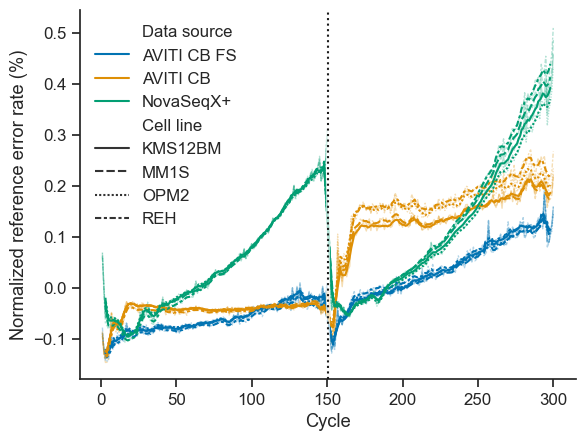

In [401]:
ax = sns.lineplot(data, x="Cycle", y="Mismatches per base norm", hue="Data source", units="Read", 
                 style="Cell line", alpha=0.3, legend=False, lw=1, hue_order=run_names.values())
ax = sns.lineplot(data, x="Cycle", y="Mismatches per base smoothed", hue="Data source", hue_order=run_names.values(),
                 style="Cell line")
ax.set_ylabel("Normalized reference error rate (%)")
ax.legend(frameon=False, framealpha=0)
ax.axvline(150.5, color="k", ls=":", zorder=3)
ax.axvline(150.5, color="w", lw=3, alpha=0.7, zorder=2)
fig = ax.get_figure()
fig.savefig(figdir / "error_rate_vs_reference_by_cycle.svg")

## Substitutions Q30+

In [411]:
data = []
for run, cell, read, file in files():
    key = "FFQ" if read == "R1" else "LFQ"
    d = grep_file(file, key)
    d = d.astype({c: int for c in d.columns})
    quals = list(range(0,d.shape[1]-1))
    
    columns = ["Cycle"] + quals
    d.columns = columns
    d["Cycle_orig"] = d["Cycle"]
    if read == "R2":
        d["Cycle"] += 150
    
    
    m = grep_file(file, "MPC")
    m = m.astype({c: int for c in m.columns})
    quals = list(range(0,m.shape[1]-2))
    columns = ["Cycle", "N"] + quals
    m.columns = columns
    
    d["Bases total"] = d[quals].sum(axis=1)

    #quals = [q for q in quals if  q <= 2] # QBIN 0: 0-2
    #quals = [q for q in quals if  q > 2] # QBIN 0: 0-2
    #quals = [q for q in quals if 3 <= q <= 17] # QBIN 12: 3-17
    #quals = [q for q in quals if  q > 17] # QBIN 0: 0-2
    #quals = [q for q in quals if 18 <= q <= 29] # QBIN 24: 18-29
    quals = [q for q in quals if q >= 30] # QBIN 40: 30+
    #quals = [q for q in quals if q < 30] # QBIN 40: <30

    d["AverageQ"] = d[quals].dot(np.array(quals)) / d[quals].sum(axis=1)
    d["Bases"] = d[quals].sum(axis=1)
    d["Mismatches"] = m[quals].sum(axis=1)
    d["Mismatches per base"] = 100 *  d["Mismatches"] / d["Bases"] 
    d["Q30 bases"] = 100 * d["Bases"] / d["Bases total"]
    d["Read"] = read
    d["Run"] = run
    d["Cell line"] = cell
    #d = d.drop(columns=quals)
    data.append(d)

data = pd.concat(data).reset_index()
data = data.fillna(0.0)
data["Data source"] = data["Run"].replace(run_names)

# Normalize data across cell lines and make minimum zero
data["Mismatches per base norm"] = data.groupby(["Cell line"])["Mismatches per base"].transform(lambda x: x - x.median())

# Smooth data
data["Mismatches per base smoothed"] = data.groupby(["Run", "Cell line", "Read"])["Mismatches per base norm"].transform(
    lambda x: x.rolling(5, center=True).mean()
)
data

,index,Cycle,0,1,2,3,4,5,6,7,...,Bases,Mismatches,Mismatches per base,Q30 bases,Read,Run,Cell line,Data source,Mismatches per base norm,Mismatches per base smoothed
0,0,1,4,0,0,46,64,70,86,53,...,4604113,6726,0.146087,99.593352,R1,aviti_ngi,KMS12BM,AVITI CB FS,0.033563,NaN
1,1,2,8898,0,1,31,36,44,25,46,...,4600700,5800,0.126068,99.519524,R1,aviti_ngi,KMS12BM,AVITI CB FS,0.013544,NaN
2,2,3,224,0,0,23,58,42,21,44,...,4608856,4956,0.107532,99.695949,R1,aviti_ngi,KMS12BM,AVITI CB FS,-0.004992,0.006208
3,3,4,1,0,0,50,84,61,63,62,...,4605580,4923,0.106892,99.625085,R1,aviti_ngi,KMS12BM,AVITI CB FS,-0.005632,-0.000636
4,4,5,2,0,2,140,140,155,97,129,...,4595660,4921,0.107079,99.410501,R1,aviti_ngi,KMS12BM,AVITI CB FS,-0.005445,-0.003383
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3595,145,296,0,0,0,0,0,0,0,0,...,11448492,14302,0.124925,88.700274,R2,xplus_sns,REH,NovaSeqX+,0.002977,0.009940
3596,146,297,0,0,16,0,0,0,0,0,...,11412109,14461,0.126716,88.418387,R2,xplus_sns,REH,NovaSeqX+,0.004768,0.011266
3597,147,298,0,0,45,0,0,0,0,0,...,11386653,15105,0.132655,88.221159,R2,xplus_sns,REH,NovaSeqX+,0.010707,0.015816
3598,148,299,0,0,183,0,0,0,0,0,...,11365791,16023,0.140976,88.059525,R2,xplus_sns,REH,NovaSeqX+,0.019028,NaN


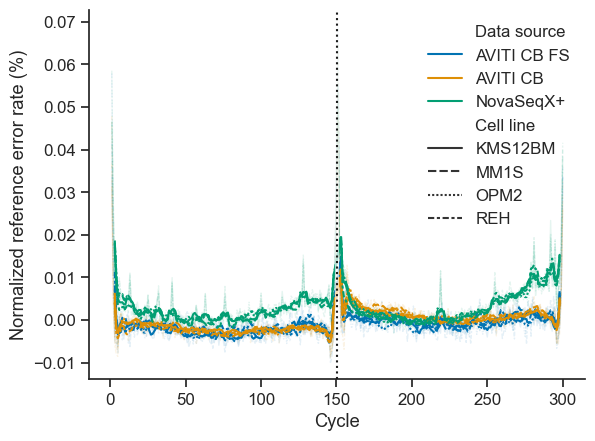

In [412]:

ax = sns.lineplot(data, x="Cycle", y="Mismatches per base norm", hue="Data source", 
                 style="Cell line", alpha=0.1, legend=False, lw=1, hue_order=run_names.values())
ax = sns.lineplot(data, x="Cycle", y="Mismatches per base smoothed", hue="Data source", hue_order=run_names.values(),
                 style="Cell line")
ax.set_ylabel("Normalized reference error rate (%)")
ax.legend(frameon=False, framealpha=0)
ax.axvline(150.5, color="k", ls=":", zorder=3)
ax.axvline(150.5, color="w", lw=3, alpha=0.7, zorder=2)

fig = ax.get_figure()
#fig.savefig(figdir / "error_rate_vs_reference_by_cycle.svg")

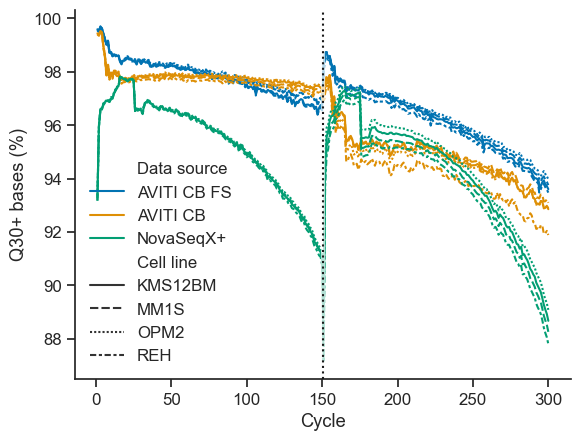

In [415]:

ax = sns.lineplot(data, x="Cycle", y="Q30 bases", hue="Data source", hue_order=run_names.values(),
                 style="Cell line")
ax.set_ylabel("Q30+ bases (%)")
ax.legend(frameon=False, framealpha=0)
ax.axvline(150.5, color="k", ls=":", zorder=3)
ax.axvline(150.5, color="w", lw=3, alpha=0.7, zorder=2)

fig = ax.get_figure()
#fig.savefig(figdir / "error_rate_vs_reference_by_cycle.svg")

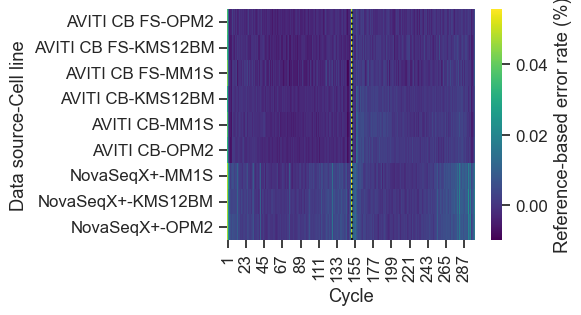

In [336]:
d = data.pivot(index=["Data source", "Cell line"], columns="Cycle", values="Mismatches per base norm")
d["Median"] = d.median(axis=1)
d = d.sort_values("Median")
d = d.drop(columns="Median")
fig, ax = plt.subplots(figsize=(4, 3))
ax = sns.heatmap(d, cmap="viridis", cbar_kws=dict(label="Reference-based error rate (%)"))
ax.axvline(150.5, color="k", ls=":", zorder=3)

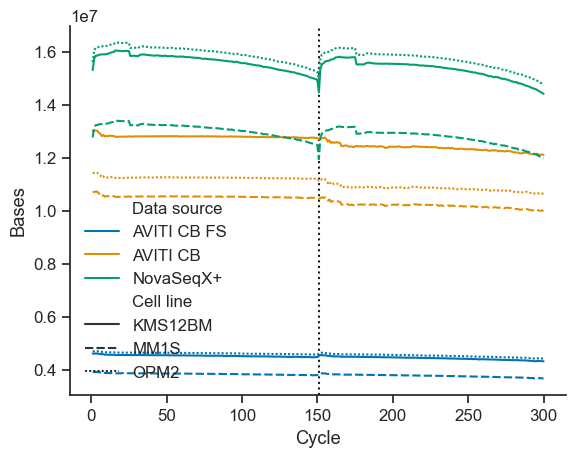

In [337]:
ax = sns.lineplot(data, x="Cycle", y="Bases", hue="Data source", 
                 style="Cell line")
#ax.set_ylabel("Reference-based error rate (%)")
ax.legend(frameon=False, framealpha=0)
ax.axvline(151, color="k", ls=":", zorder=-1)

fig = ax.get_figure()
#fig.savefig(figdir / "error_rate_vs_reference_by_cycle.svg")

## Substitutions <Q30

In [375]:
data = []
for run, cell, read, file in files():
    key = "FFQ" if read == "R1" else "LFQ"
    d = grep_file(file, key)
    d = d.astype({c: int for c in d.columns})
    quals = list(range(0,d.shape[1]-1))
    
    columns = ["Cycle"] + quals
    d.columns = columns
    d["Cycle_orig"] = d["Cycle"]
    if read == "R2":
        d["Cycle"] += 150
    
    
    m = grep_file(file, "MPC")
    m = m.astype({c: int for c in m.columns})
    quals = list(range(0,m.shape[1]-2))
    columns = ["Cycle", "N"] + quals
    m.columns = columns
    

    #quals = [q for q in quals if  q <= 2] # QBIN 0: 0-2
    #quals = [q for q in quals if  q > 2] # QBIN 0: 0-2
    #quals = [q for q in quals if 3 <= q <= 17] # QBIN 12: 3-17
    #quals = [q for q in quals if  q > 17] # QBIN 0: 0-2
    #quals = [q for q in quals if 18 <= q <= 29] # QBIN 24: 18-29
    #quals = [q for q in quals if q >= 30] # QBIN 40: 30+
    quals = [q for q in quals if q < 30] # QBIN 40: <30

    d["AverageQ"] = d[quals].dot(np.array(quals)) / d[quals].sum(axis=1)
    d["Bases"] = d[quals].sum(axis=1)
    d["Mismatches"] = m[quals].sum(axis=1)
    d["Mismatches per base"] = 100 *  d["Mismatches"] / d["Bases"] 
    
    d["Read"] = read
    d["Run"] = run
    d["Cell line"] = cell
    #d = d.drop(columns=quals)
    data.append(d)

data = pd.concat(data).reset_index()
data = data.fillna(0.0)
data["Data source"] = data["Run"].replace(run_names)

data["Mismatches per base norm"] = data.groupby(["Cell line"])["Mismatches per base"].transform(lambda x: x - x.median())
data["Mismatches per base smoothed"] = data.groupby(["Run", "Cell line", "Read"])["Mismatches per base norm"].transform(lambda x: x.rolling(5, center=True).mean())
data

,index,Cycle,0,1,2,3,4,5,6,7,...,AverageQ,Bases,Mismatches,Mismatches per base,Read,Run,Cell line,Data source,Mismatches per base norm,Mismatches per base smoothed
0,0,1,4,0,0,46,64,70,86,53,...,24.358423,18799,401,2.133092,R1,aviti_ngi,KMS12BM,AVITI CB FS,-2.364878,NaN
1,1,2,8898,0,1,31,36,44,25,46,...,14.555330,22212,207,0.931929,R1,aviti_ngi,KMS12BM,AVITI CB FS,-3.566042,NaN
2,2,3,224,0,0,23,58,42,21,44,...,24.002134,14056,107,0.761241,R1,aviti_ngi,KMS12BM,AVITI CB FS,-3.736730,-3.194740
3,3,4,1,0,0,50,84,61,63,62,...,23.946169,17332,208,1.200092,R1,aviti_ngi,KMS12BM,AVITI CB FS,-3.297878,-3.019978
4,4,5,2,0,2,140,140,155,97,129,...,23.253486,27252,406,1.489799,R1,aviti_ngi,KMS12BM,AVITI CB FS,-3.008172,-2.367769
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3595,145,296,0,0,0,0,0,0,0,0,...,19.190568,1458449,68543,4.699719,R2,xplus_sns,REH,NovaSeqX+,0.276266,0.607793
3596,146,297,0,0,16,0,0,0,0,0,...,19.150513,1494832,72740,4.866099,R2,xplus_sns,REH,NovaSeqX+,0.442646,0.565897
3597,147,298,0,0,45,0,0,0,0,0,...,19.136615,1520288,75827,4.987673,R2,xplus_sns,REH,NovaSeqX+,0.564221,0.532426
3598,148,299,0,0,183,0,0,0,0,0,...,19.137744,1541150,77409,5.022808,R2,xplus_sns,REH,NovaSeqX+,0.599355,NaN


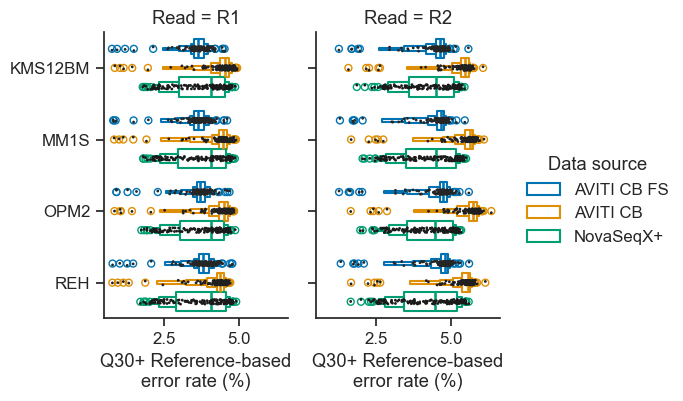

In [376]:
g = sns.catplot(data, y="Cell line", x="Mismatches per base", hue="Data source",
                col = "Read", kind="boxen", height=4, aspect=0.7, fill=False,
                   palette="colorblind")
g.map_dataframe(sns.stripplot, y="Cell line", x="Mismatches per base", hue="Data source",
                dodge=True, palette="dark:k", s=2)
g.set_axis_labels("Q30+ Reference-based\nerror rate (%)", "")


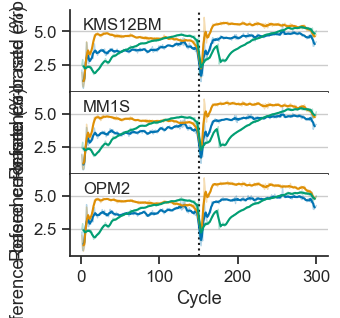

In [341]:
data["Mismatches per base smoothed"] = data.groupby(["Run", "Cell line", "Read"])["Mismatches per base"].transform(lambda x: x.rolling(5, center=True).mean())

g = sns.relplot(data, x="Cycle", y="Mismatches per base", hue="Data source", kind="line",
                row="Cell line", alpha=0.3, lw=1, legend=False, height=1.2, aspect=3,
                facet_kws=dict(sharey=True))
g.map_dataframe(sns.lineplot, data=data, x="Cycle", y="Mismatches per base smoothed", hue="Data source", 
                )

g.set(ylabel="Reference-based error rate (%)")
ax.legend(frameon=False, framealpha=0)
g.refline(x=150.5, color="k", ls=":", zorder=-1)
g.fig.subplots_adjust(hspace=00)
for cell, ax in g.axes_dict.items():
    ax.grid(True, axis="y")
    ax.annotate(cell, (0.05, 0.9), xycoords="axes fraction", va="top", ha="left", fontsize=12)
    ax.set_title("")

fig = ax.get_figure()
#fig.savefig(figdir / "error_rate_vs_reference_by_cycle.svg")

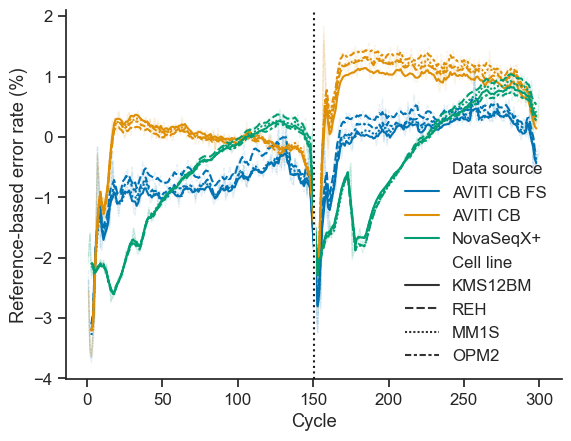

In [378]:
data = data.sort_values("Cycle")
data["Mismatches per base norm"] = data.groupby(["Cell line"])["Mismatches per base"].transform(lambda x: x - x.median())
data["Mismatches per base smoothed"] = data.groupby(["Run", "Cell line", "Read"])["Mismatches per base norm"].transform(
    lambda x: x.rolling(5, center=True).mean()
)

ax = sns.lineplot(data, x="Cycle", y="Mismatches per base norm", hue="Data source", 
                 style="Cell line", alpha=0.1, legend=False, lw=1, hue_order=run_names.values())
ax = sns.lineplot(data, x="Cycle", y="Mismatches per base smoothed", hue="Data source", hue_order=run_names.values(),
                 style="Cell line")
ax.set_ylabel("Reference-based error rate (%)")
ax.legend(frameon=False, framealpha=0)
ax.axvline(150.5, color="k", ls=":", zorder=3)
ax.axvline(150.5, color="w", lw=2, zorder=2)

fig = ax.get_figure()
#fig.savefig(figdir / "error_rate_vs_reference_by_cycle.svg")

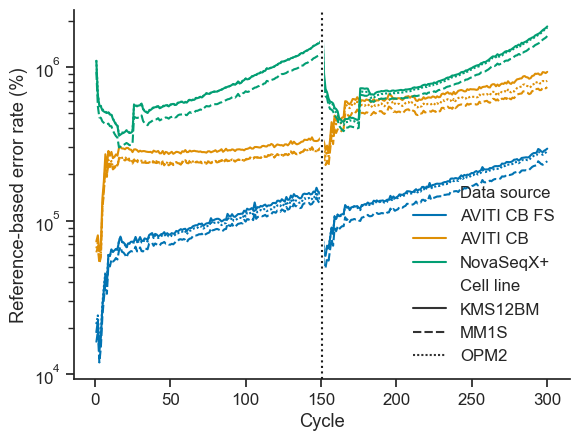

In [348]:
ax = sns.lineplot(data, x="Cycle", y="Bases", hue="Data source", 
                 style="Cell line", hue_order=run_names.values())
ax.set_ylabel("Reference-based error rate (%)")
ax.set_yscale("log")
ax.legend(frameon=False, framealpha=0)
ax.axvline(150.5, color="k", ls=":", zorder=3)
ax.axvline(150.5, color="w", lw=3, zorder=2)

fig = ax.get_figure()
#fig.savefig(figdir / "error_rate_vs_reference_by_cycle.svg")

## Substitutions + Indels

In [95]:
datai = []
for run, cell, read, file in files():
    key = "FFQ" if read == "R1" else "LFQ"
    d = grep_file(file, key)
    d = d.astype({c: int for c in d.columns})
    quals = list(range(0,d.shape[1]-1))
    columns = ["Cycle"] + quals
    d.columns = columns
    if read == "R2":
        d["Cycle"] += 150

    d["AverageQ"] = d[quals].dot(np.array(quals)) / d[quals].sum(axis=1)
    
    d["Bases"] = d[quals].sum(axis=1)
    d = d.drop(columns=quals)
    
    m = grep_file(file, "MPC")
    m = m.astype({c: int for c in m.columns})
    quals = list(range(0,m.shape[1]-2))
    columns = ["Cycle", "N"] + quals
    m.columns = columns

    d["Substitutions"] = m[quals].sum(axis=1)
    d["Substitutions per base"] = 1000 * d["Substitutions"] / d["Bases"] 

    # IC reports the frequency of indels occurring per cycle, broken down by both 
    # insertion / deletion and by first / last read. Note for multi-base indels 
    # this only counts the first base location. Columns are cycle, number of 
    # insertions in first fragments, number of insertions in last fragments, 
    # number of deletions in first fragments, and number of deletions in last fragments.
    ic = grep_file(file, "IC")
    ic = ic.astype({c: int for c in ic.columns})
    columns = ["Cycle", "InsR1", "InsR2", "DelR1", "DelR2"]
    ic.columns = columns

    indel_cols = ["InsR1", "DelR1"] if read == "R1" else ["InsR2", "DelR2"]
    d["Indels"] = ic[indel_cols].sum(axis=1)
    d["Indels per base"] = 1000 * d["Indels"] / d["Bases"]

    d["Ins"] = ic[indel_cols[0]]
    d["Del"] = ic[indel_cols[1]]
    
    d["Mismatches"] = d[["Substitutions","Indels"]].sum(axis=1)
    d["Mismatches per base"] = 1000 * d["Mismatches"] / d["Bases"]
    
    d["Read"] = read
    d["Run"] = run
    d["Cell line"] = cell
    datai.append(d)

datai = pd.concat(datai).reset_index()
datai = datai.fillna(0.0)
datai["Data source"] = datai["Run"].replace(run_names)
datai

,index,Cycle,AverageQ,Bases,Substitutions,Substitutions per base,Indels,Indels per base,Ins,Del,Mismatches,Mismatches per base,Read,Run,Cell line,Data source
0,0,1,37.299037,4622912,7127,1.541669,207.0,0.044777,0.0,207.0,7334.0,1.586446,R1,aviti_ngi,KMS12BM,AVITI CB FS
1,1,2,42.334874,4622912,6007,1.299397,481.0,0.104047,242.0,239.0,6488.0,1.403444,R1,aviti_ngi,KMS12BM,AVITI CB FS
2,2,3,42.394971,4622912,5063,1.095197,519.0,0.112267,283.0,236.0,5582.0,1.207464,R1,aviti_ngi,KMS12BM,AVITI CB FS
3,3,4,42.357160,4622912,5131,1.109906,565.0,0.122217,296.0,269.0,5696.0,1.232124,R1,aviti_ngi,KMS12BM,AVITI CB FS
4,4,5,42.281821,4622912,5327,1.152304,693.0,0.149906,356.0,337.0,6020.0,1.302210,R1,aviti_ngi,KMS12BM,AVITI CB FS
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3595,145,296,37.648591,12906941,82845,6.418639,1389.0,0.107617,571.0,818.0,84234.0,6.526256,R2,xplus_sns,REH,NovaSeqX+
3596,146,297,37.585293,12906941,87201,6.756132,0.0,0.000000,0.0,0.0,87201.0,6.756132,R2,xplus_sns,REH,NovaSeqX+
3597,147,298,37.542535,12906941,90932,7.045201,0.0,0.000000,0.0,0.0,90932.0,7.045201,R2,xplus_sns,REH,NovaSeqX+
3598,148,299,37.508948,12906941,93432,7.238896,0.0,0.000000,0.0,0.0,93432.0,7.238896,R2,xplus_sns,REH,NovaSeqX+


<Axes: ylabel='Data source,Cell line'>

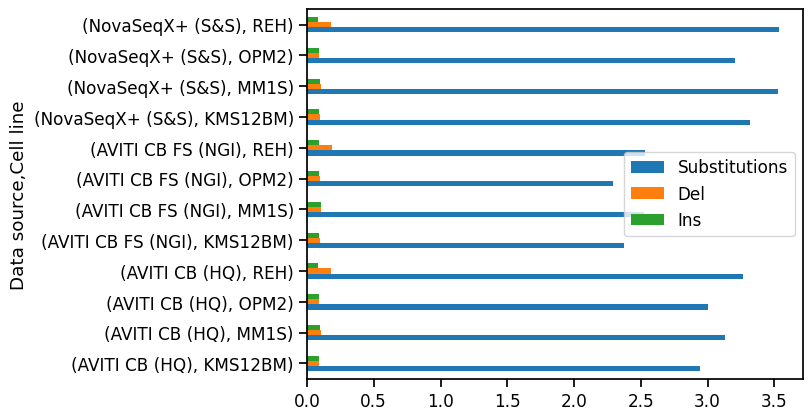

In [65]:
d = datai.groupby(["Data source", "Cell line"])[["Bases", "Substitutions","Del","Ins"]].sum()
d = d.div(d["Bases"], axis=0) * 1000
d = d.drop(columns="Bases")
d.plot.barh()

Text(0, 0.5, '% of bases')

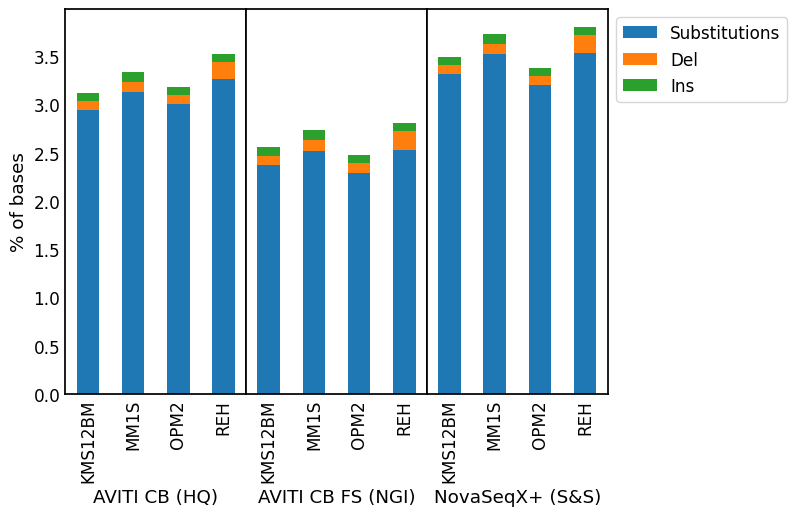

In [66]:
d = datai.groupby(["Data source", "Cell line"])[["Bases", "Substitutions","Del","Ins"]].sum()
d = d.div(d["Bases"], axis=0) * 1000
d = d.reset_index()
groups = d.groupby("Data source")
fig, axes = plt.subplots(1, len(groups), sharex=True, sharey=True, figsize=(7,5))

for ax, (source, group) in zip(axes, groups):
    # The rename_axis function makes the difference
    group.set_index("Cell line").rename_axis(source)[["Substitutions","Del","Ins"]].plot.bar(ax=ax, stacked=True)
    ax.tick_params(axis='both', which='both', length=0)
    ax.get_legend().remove()

fig.subplots_adjust(wspace=0)
plt.legend(bbox_to_anchor=(1, 1)) #, loc="best")
axes[0].set_ylabel("% of bases")

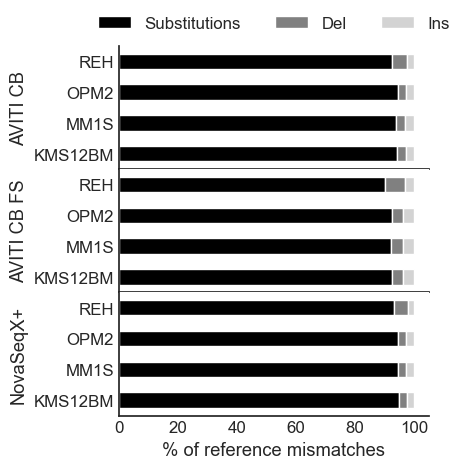

In [117]:
d = datai.groupby(["Data source", "Cell line"])[["Substitutions","Del","Ins"]].sum()
d = d.apply(lambda x: 100* x/x.sum(), axis=1)
d = d.reset_index()

groups = d.groupby("Data source")
fig, axes = plt.subplots(len(groups), 1, sharex=True, sharey=True, figsize=(4, 4.8))

colors = {
    "Substitutions": "black",
    "Del": "grey",
    "Ins": "lightgrey",
}

for ax, (source, group) in zip(axes, groups):
    # The rename_axis function makes the difference
    group.set_index("Cell line").rename_axis(source)[
        colors.keys()
    ].plot.barh(ax=ax, stacked=True, color=colors)
    ax.tick_params(axis='both', which='both', length=0)
    ax.get_legend().remove()

fig.subplots_adjust(hspace=0)
axes[0].legend(bbox_to_anchor=(0.5, 1), ncol=3, frameon=False, loc="lower center")
axes[-1].set_xlabel("% of reference mismatches")
fig.savefig(figdir / "error_rates_stacked_by_type.svg", backend='svg', 
            transparent=True, dpi=300, bbox_inches='tight')


### INDELs

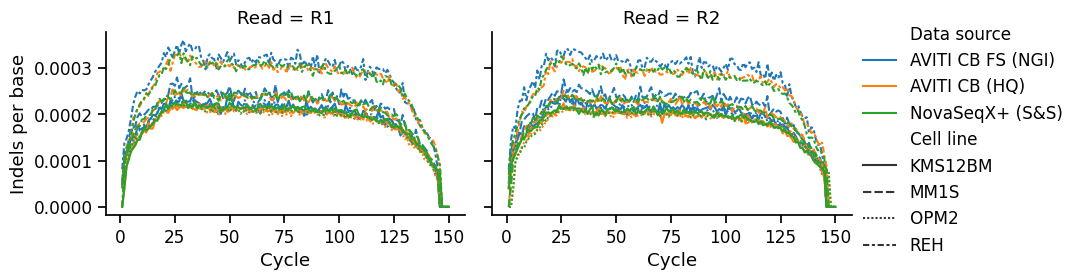

In [18]:
g = sns.relplot(datai, x="Cycle", y="Indels per base", kind="line", hue="Data source", style="Cell line", col="Read", aspect=1.5, height=3)


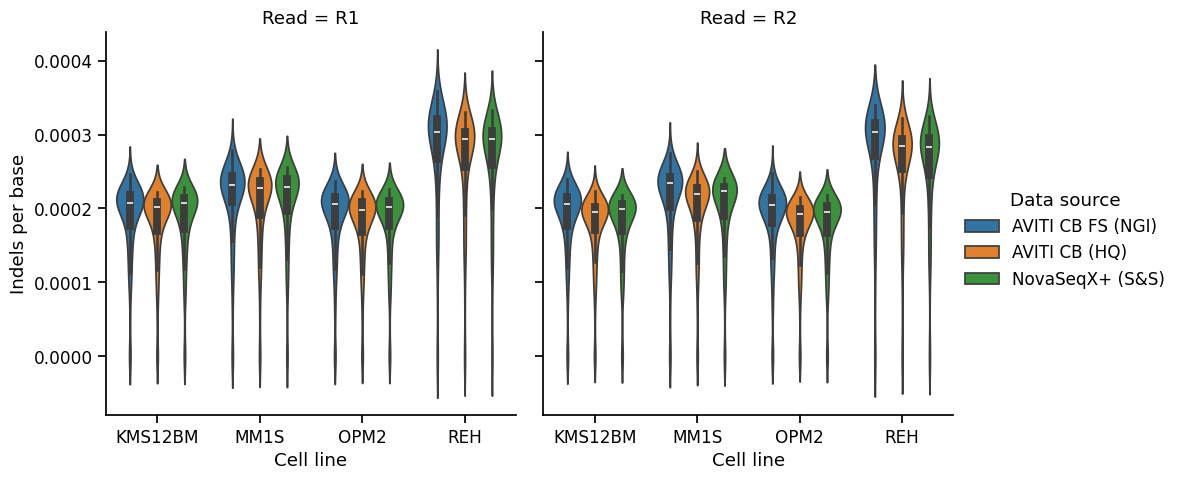

In [19]:
g = sns.catplot(datai, x="Cell line", y="Indels per base", hue="Data source", hue_order=run_names.values(), 
                col="Read", kind="violin")


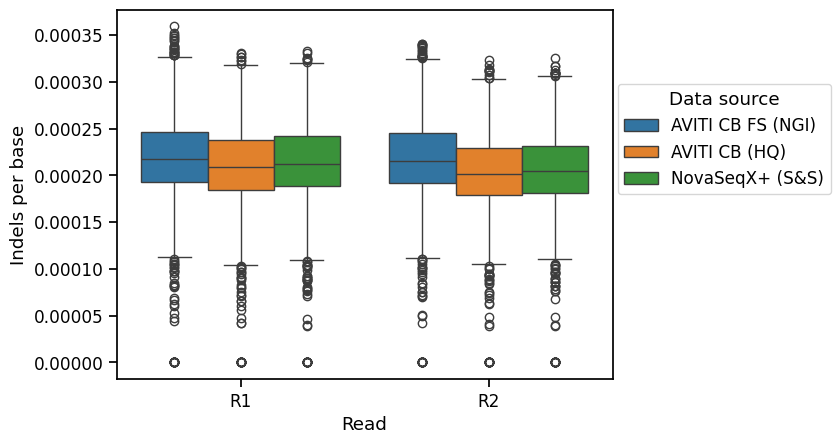

In [20]:
g = sns.boxplot(datai, x="Read", y="Indels per base", hue="Data source", hue_order=run_names.values())
sns.move_legend(g, loc=(1.01,0.5))


### Subs + INDELs

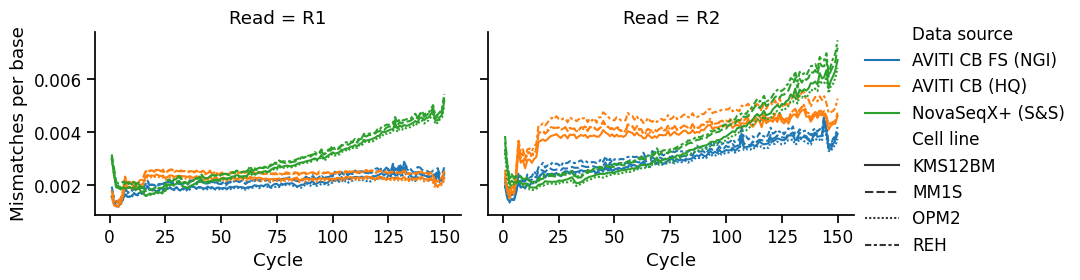

In [21]:
g = sns.relplot(datai, x="Cycle", y="Mismatches per base", kind="line", hue="Data source", style="Cell line", col="Read", aspect=1.5, height=3)


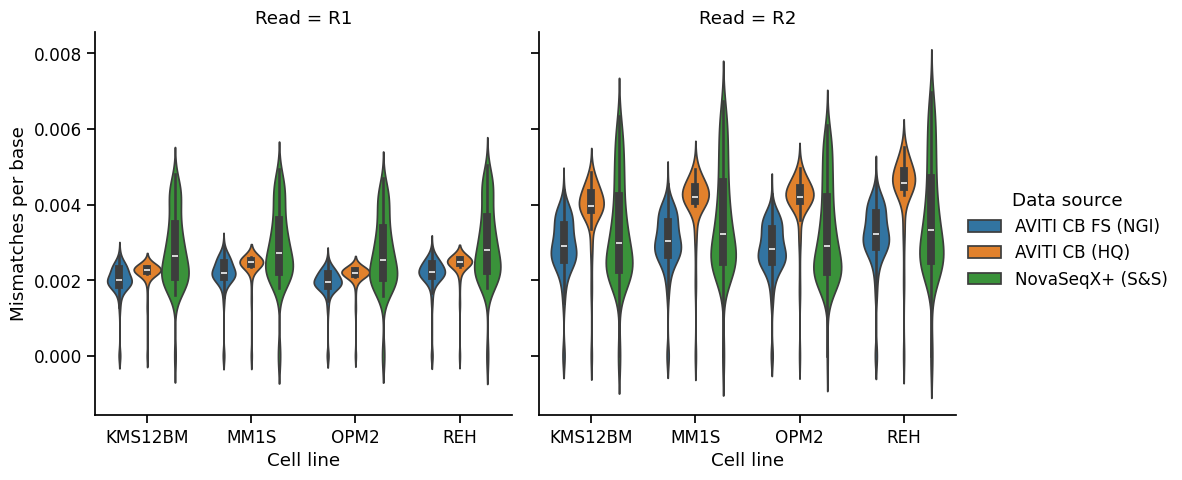

In [177]:
g = sns.catplot(datai, x="Cell line", y="Mismatches per base", hue="Data source", hue_order=run_names.values(), 
                col="Read", kind="violin")


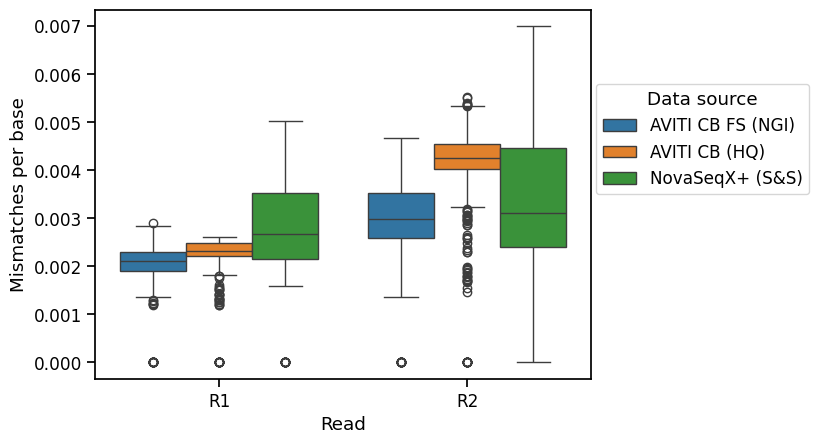

In [178]:
g = sns.boxplot(datai, x="Read", y="Mismatches per base", hue="Data source", hue_order=run_names.values())
sns.move_legend(g, loc=(1.01,0.5))
